# Baseline Test

In [3]:
import pandas as pd
import numpy as np
#NLTK
import string
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
#Sklearn
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report 
#Matplotlib
import matplotlib
from matplotlib import pyplot as plt
import re
%matplotlib inline

/home/ayu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
df_listings=pd.read_csv('listings/listings.csv')

/home/ayu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (43,61,62,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_reviews=pd.read_csv('reviews/reviews.csv')

In [6]:
df_reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2515,198,2008-10-13,2603,Jenny,Stephanie was a wonderful host! Her apartment ...
1,2515,859,2009-03-08,8455,Roland,Such a wonderful place and very close to the m...
2,2515,1083,2009-03-25,9759,Cem,I just got back from a trip to NYC during whic...
3,2515,1107,2009-03-27,9193,Holly,Stephanie's offered all the most important thi...
4,2515,2175,2009-05-09,7048,Alessandra,"Stephanie was really nice, ftiendly and helpfu..."


In [7]:
#fill nans with none in comments
df_reviews.comments.fillna('none',inplace=True)

#### Check how many rows have the word super host in it

In [8]:
df_reviews[df_reviews.comments.str.contains('super host')==True].shape

(1217, 6)

In [9]:
df_reviews[df_reviews.comments.str.contains('superhost')==True].shape

(290, 6)

#### Replace all superhost strings with a blank space in each "review"

In [10]:
df_reviews.comments = df_reviews.comments.str.replace("superhost","")

In [11]:
df_reviews.comments = df_reviews.comments.str.replace("super host","")

In [12]:
#join all reviews together by listing_id (this will allow me run tf-idf on all my reviews together and look for topics/features)
df_reviews=df_reviews.groupby(['listing_id'])['comments'].apply(','.join).reset_index()

In [13]:
df_reviews.head(5)

,listing_id,comments
0,2515,Stephanie was a wonderful host! Her apartment ...
1,2539,"Great host ,Nice room for the price. Great nei..."
2,2595,Notre séjour de trois nuits.\r\nNous avons app...
3,3330,I haven't met Julia but her place is very nice...
4,3831,"lisa is a wonderful, kind and thoughtful host...."


In [14]:
df_combined=pd.merge(df_listings, df_reviews, left_on='id', right_on='listing_id', how='left')

In [15]:
df_combined.host_is_superhost.isnull().sum()

106

In [16]:
df_combined['host_is_superhost'].fillna('f', inplace = True)

In [17]:
df_combined.replace({'host_is_superhost': {'t': True, 'f': False}},inplace=True)

In [18]:
df_combined.comments.isnull().sum()

10936

In [19]:
#update df_combined to only include reviews 
df_combined=df_combined[df_combined.comments.isnull()==False]

In [20]:
df_combined.shape

(37916, 98)

In [21]:
df_combined[df_combined.host_is_superhost==True].shape

(6322, 98)

In [22]:
6322/37916

0.1667369975735837

In [23]:
new_df=df_combined

In [24]:
super_pop = int(new_df.shape[0]*.16673)
super_pop

6321

In [25]:
reg_pop = int(new_df.shape[0]*(1 - .16673))
reg_pop

31594

In [26]:
sample_size = 37916
super_perc = .16673


reg_perc = 1 - super_perc

# Sample sizes
super_sample_size = int(sample_size * super_perc)
reg_sample_size = int(sample_size * reg_perc)

supers = new_df[new_df.host_is_superhost == 1]
regs = new_df[new_df.host_is_superhost == 0]

super_samples = supers.sample(super_sample_size)
reg_samples = regs.sample(reg_sample_size)

df_sample = super_samples.append(reg_samples)

In [27]:
df_sample.host_is_superhost.value_counts()

False    31594
True      6321
Name: host_is_superhost, dtype: int64

In [28]:
print(super_samples.shape)
super_samples.host_is_superhost.unique()

(6321, 98)


array([ True])

In [29]:
print(reg_samples.shape)
reg_samples.host_is_superhost.unique()

(31594, 98)


array([False])

### NLP Scrubber

In [30]:
#punctuation remover
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [28]:
df_sample['comments'] = df_sample['comments'].apply(remove_punctuation)

In [29]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [30]:
df_sample['comments'] = df_sample['comments'].apply(stemming)

In [32]:
def plot_roc(y_test, X_test, model, model_name):
    try:
        AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic {}'.format(model_name))
        plt.legend(loc="lower right");
    except:
        None

In [33]:
def train_predict(classifier, X, y):
    #train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
    #fit_classifier
    classifier.fit(X_train, y_train)
    y_predictions = classifier.predict(X_test)
    print("Accuracy")
    #train_test_accuracy
    print ("Train Accuracy : {}".format(accuracy_score(y_train, classifier.predict(X_train))))
    print ("Test Accuracy  : {}".format(accuracy_score(y_test, y_predictions)))
    print("")
    print("Confusion Matrix")
    #confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()
    print("True Negative: {}".format(tn))
    print("True Positive: {}".format(tp))
    print("False Negative: {}".format(fn))
    print("False Positive: {}".format(fp))
    print("")
    #classification_report
    print("Classification Report")
    print(classification_report(y_test, y_predictions, target_names=['Not_Superhost', 'Superhost']))
    #roc_curve
    print("")
    plot_roc(y_test, X_test, model=classifier, model_name="classifier")
    return None

## CountVectorizer only

### Naive Bayes Baseline

Accuracy
Train Accuracy : 0.847939231959488
Test Accuracy  : 0.7718113725076485

Confusion Matrix
True Negative: 6493
True Positive: 823
False Negative: 757
False Positive: 1406

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.90      0.82      0.86      7899
    Superhost       0.37      0.52      0.43      1580

  avg / total       0.81      0.77      0.79      9479




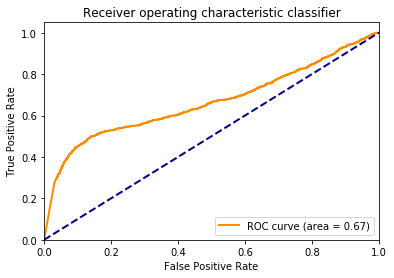

In [54]:
trial = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', MultinomialNB())
])

train_predict(trial, df_sample['comments'], df_sample['host_is_superhost'])

### Logistic Regression Baseline

Accuracy
Train Accuracy : 0.9516106344070896
Test Accuracy  : 0.8671800822871611

Confusion Matrix
True Negative: 7508
True Positive: 712
False Negative: 868
False Positive: 391

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.90      0.95      0.92      7899
    Superhost       0.65      0.45      0.53      1580

  avg / total       0.85      0.87      0.86      9479




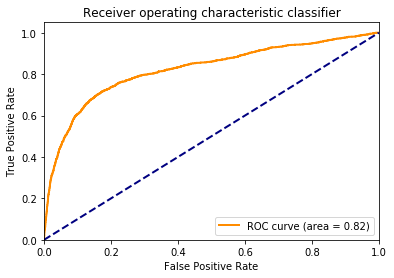

In [55]:
trial1 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', LogisticRegression())
])

train_predict(trial1, df_sample['comments'], df_sample['host_is_superhost'])

### Random Forest Classifier Baseline

Accuracy
Train Accuracy : 0.9822759881839921
Test Accuracy  : 0.8354256778141154

Confusion Matrix
True Negative: 7749
True Positive: 170
False Negative: 1410
False Positive: 150

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.85      0.98      0.91      7899
    Superhost       0.53      0.11      0.18      1580

  avg / total       0.79      0.84      0.79      9479




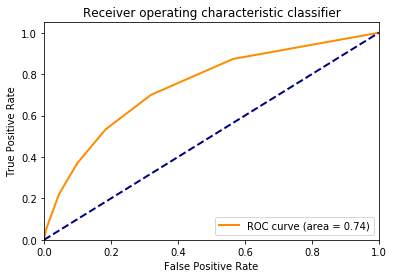

In [56]:
trial2 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', RandomForestClassifier())
])

train_predict(trial2, df_sample['comments'], df_sample['host_is_superhost'])

### Gradient Boosting Classifier Baseline

Accuracy
Train Accuracy : 0.8802222534815023
Test Accuracy  : 0.8673910750079122

Confusion Matrix
True Negative: 7639
True Positive: 583
False Negative: 997
False Positive: 260

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.97      0.92      7899
    Superhost       0.69      0.37      0.48      1580

  avg / total       0.85      0.87      0.85      9479




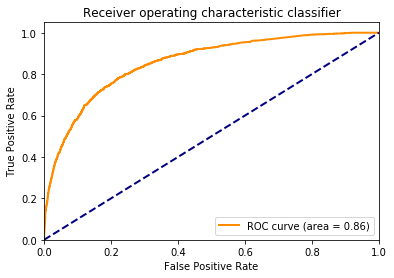

In [57]:
trial3 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', GradientBoostingClassifier())
])

train_predict(trial3, df_sample['comments'], df_sample['host_is_superhost'])

### LinearSVC Baseline

In [132]:
trial4 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', LinearSVC())
])

train_predict(trial4, df_sample['comments'], df_sample['host_is_superhost'])

Accuracy
Train Accuracy : 0.9977141651427768
Test Accuracy  : 0.8219221436860429

Confusion Matrix
True Negative: 7106
True Positive: 685
False Negative: 895
False Positive: 793

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.89      0.90      0.89      7899
    Superhost       0.46      0.43      0.45      1580

  avg / total       0.82      0.82      0.82      9479




## TfidfVectorizer only

### Naive Bayes Baseline

Accuracy
Train Accuracy : 0.8332747221831481
Test Accuracy  : 0.8332102542462285

Confusion Matrix
True Negative: 7898
True Positive: 0
False Negative: 1580
False Positive: 1

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.83      1.00      0.91      7899
    Superhost       0.00      0.00      0.00      1580

  avg / total       0.69      0.83      0.76      9479




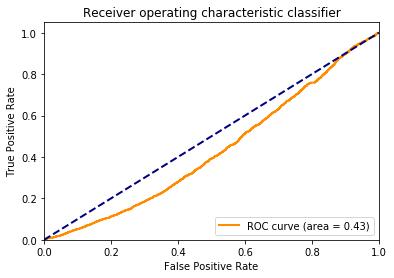

In [58]:
trial5 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', MultinomialNB())
])

train_predict(trial5, df_sample['comments'], df_sample['host_is_superhost'])

### Logistic Regression Baseline

Accuracy
Train Accuracy : 0.8602475734983823
Test Accuracy  : 0.8423884375989028

Confusion Matrix
True Negative: 7694
True Positive: 291
False Negative: 1289
False Positive: 205

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.86      0.97      0.91      7899
    Superhost       0.59      0.18      0.28      1580

  avg / total       0.81      0.84      0.81      9479




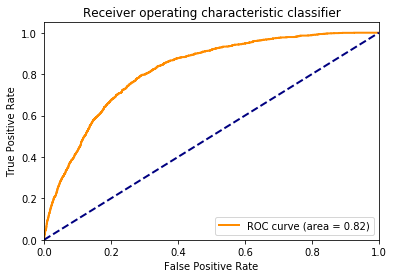

In [59]:
trial6 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', LogisticRegression())
])

train_predict(trial6, df_sample['comments'], df_sample['host_is_superhost'])

### Random Forest Classifier Baseline

Accuracy
Train Accuracy : 0.980834153889436
Test Accuracy  : 0.837957590463129

Confusion Matrix
True Negative: 7771
True Positive: 172
False Negative: 1408
False Positive: 128

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.85      0.98      0.91      7899
    Superhost       0.57      0.11      0.18      1580

  avg / total       0.80      0.84      0.79      9479




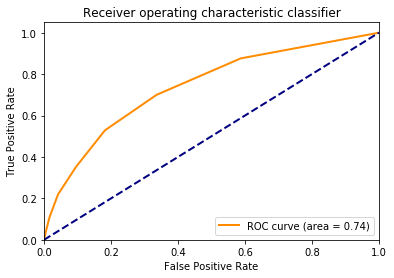

In [60]:
trial7 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', RandomForestClassifier())
])

train_predict(trial7, df_sample['comments'], df_sample['host_is_superhost'])

### Gradient Boosting Classifier Baseline

Accuracy
Train Accuracy : 0.8838444225629484
Test Accuracy  : 0.8678130604494145

Confusion Matrix
True Negative: 7661
True Positive: 565
False Negative: 1015
False Positive: 238

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.97      0.92      7899
    Superhost       0.70      0.36      0.47      1580

  avg / total       0.85      0.87      0.85      9479




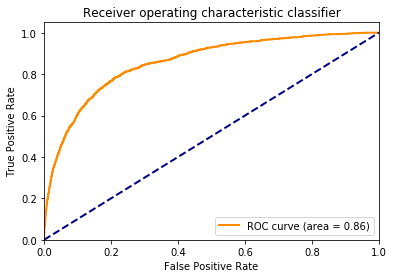

In [34]:
trial8 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', GradientBoostingClassifier())
])

train_predict(trial8, df_sample['comments'], df_sample['host_is_superhost'])

### LinearSVC Baseline

In [36]:
trial9 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', LinearSVC())
])

train_predict(trial9, df_sample['comments'], df_sample['host_is_superhost'])

Accuracy
Train Accuracy : 0.9589956393304262
Test Accuracy  : 0.8518831100327039

Confusion Matrix
True Negative: 7462
True Positive: 613
False Negative: 967
False Positive: 437

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.89      0.94      0.91      7899
    Superhost       0.58      0.39      0.47      1580

  avg / total       0.84      0.85      0.84      9479




#### Pick out the top 50 feature importance (words) from the model

In [35]:
trial8_featurenames=trial8.steps[0][1].get_feature_names()

In [36]:
trial8_importantfeats = trial8.steps[1][1].feature_importances_

In [42]:
indices = np.argsort(trial8_importantfeats)
feature_names = np.array(trial8_featurenames)[indices][-50:]

In [43]:
feature_names

array(['walkable', 'equipped', 'sleep', 'didn', 'ok', 'night',
       'superhost', 'sink', 'welcoming', 'vivement', 'communication',
       'public', 'thoughtful', 'dusty', 'hosts', 'super', 'posting',
       'wonderful', 'attentive', 'lovely', 'cons', 'home', 'comfortable',
       'casa', 'people', 'reservation', 'spotless', 'touches', 'check',
       'visit', 'stylish', 'house', 'darya', 'clean', 'beautiful', 'wasn',
       'did', 'amazing', 'snacks', 'keys', 'hospitality', 'best',
       'definitely', 'fine', 'place', 'dirty', 'canceled', 'good',
       'highly', 'automated'], dtype='<U144')